In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Settings

In [2]:
# Path settings
base_path_to_csv = "/home/SharedFolder/trained_models/night-drive/weather_classifier/"
# Settings for epoch selection method
which_mode = "best_onemetric"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "accuracy_balanced"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"
# if true, all splits are evaluated relative to A; else, B_25 is evaluated relative to B
always_substract_A = True # True
# just for the combined plot to compare trainC to AOAB and AUG50 to AOAB
additional_subtract_from_AUGONLYASBASE_for_plot = True

In [3]:
cf.go_offline(connected = True)
config = {
    "modeBarButtonsToRemove": ["sendDataToCloud"],
    "displaylogo": False
}

layout = {
    "title": "",
    "titlefont": {
        "size": 28
    },    
    "xaxis": {
        "tickfont": {
            "size": 18
        }
    },    
    "yaxis": {
        "title": "",
        "range": [-10, 15],
        "dtick": 5,
        "titlefont": {
            "size": 20
        },
        "tickfont": {
            "size": 18
        }
    },
    "width": 1024,
    "height": 768,
    "legend": {
        "x": 0.05,
        "y": -0.07,
        "orientation": "h",
        "font": {
            "size": 18,
        },        
    }
}

## Select classifier results

In [4]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy", "clear_cloudy_merged"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
num_runs = len(list_runs)
num_trials = len(list_trials)
onemetric_store = onemetric
for r, run in enumerate(list_runs):  # for each set of classifier runs
    if which_mode == "best_onemetric" and run == "with_cloudy" and onemetric == "accuracy_balanced":
        onemetric_store = onemetric  # this exception is handled cause we don't have accuracy_balanced for one of the eval runs
        onemetric = "accuracy"
    else:
        onemetric = onemetric_store
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns=["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [5]:
# All epochs
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.617242,0.5340,0.437229,0.5340,0.554173,0.758071,0.762467,0.636043,0.541513,0.249966
1,2,test,0.761013,0.7115,0.564910,0.7115,0.651598,0.889789,0.852031,0.816138,0.668131,0.383286
2,3,test,0.826901,0.8040,0.634420,0.8040,0.696667,0.931155,0.884920,0.882157,0.720388,0.482139
3,4,test,0.844982,0.8280,0.665915,0.8280,0.723152,0.942852,0.899852,0.901617,0.746401,0.523578
4,5,test,0.863000,0.8530,0.695567,0.8530,0.738314,0.951973,0.908640,0.916463,0.764847,0.562578


In [6]:
# Selected epochs
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.884665,0.808437,test,17,0.791956,0.884665,0.886574,0.693115,0.858202,0.941036,0.932166,0.966007,without_cloudy,train_A_over
1,0.935216,0.926284,test_daytime,18,0.907625,0.935216,0.936393,0.867401,0.956008,0.976888,0.986231,0.987518,without_cloudy,train_A_over
2,0.829474,0.680077,test_night,11,0.646597,0.829474,0.840338,0.470129,0.714435,0.887263,0.852201,0.935927,without_cloudy,train_A_over
3,0.923899,0.92391,train_dev_A_over,12,0.923793,0.923899,0.923793,0.886022,0.972457,0.973417,0.98534,0.984951,without_cloudy,train_A_over
4,0.884665,0.813281,valid,12,0.785361,0.884665,0.888526,0.702174,0.859195,0.941987,0.941083,0.967126,without_cloudy,train_A_over


In [7]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(df_sel_epochs.shape[0]))

## Print results for best epochs grouped by split

In [8]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy', 'accuracy_balanced', 'f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

### Valid-All

In [9]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0.884665,0.813281,0.888526,0.884665,0.785361,0.967126,0.941083,0.941987,0.859195,0.702174
1,17,train_B_over,without_cloudy,0.875644,0.8457,0.881979,0.875644,0.78965,0.96693,0.958219,0.940398,0.881621,0.700786
2,8,train_C_over,without_cloudy,0.874356,0.854211,0.881625,0.874356,0.789339,0.961089,0.955588,0.93054,0.879838,0.704526
3,12,train_A_over_ganaug_025,without_cloudy,0.856959,0.815842,0.865546,0.856959,0.756431,0.957975,0.942912,0.925863,0.856425,0.66101
4,17,train_A_over_ganaug_050,without_cloudy,0.858892,0.818306,0.867391,0.858892,0.760538,0.957904,0.942313,0.927002,0.85479,0.664374
5,14,train_B_over_ganaug_025,without_cloudy,0.909149,0.834905,0.909874,0.909149,0.827165,0.975471,0.953507,0.956608,0.882107,0.753234
6,17,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.884021,0.800664,0.886458,0.884021,0.781919,0.966968,0.938366,0.941895,0.848678,0.693216
7,36,train_A_over,with_cloudy,0.832,NaN,0.830636,0.832,0.751538,0.953876,0.927669,0.886898,0.805484,0.698413
8,35,train_B_over,with_cloudy,0.8395,NaN,0.839658,0.8395,0.775809,0.959489,0.940013,0.900689,0.840947,0.716532
9,35,train_C_over,with_cloudy,0.8285,NaN,0.829755,0.8285,0.76104,0.956511,0.939627,0.894224,0.834233,0.699818


In [10]:
# Print diffierence of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Difference to A ===")
df_cursplit_diff = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff.loc[r, metrics2print] = df_cursplit.loc[r,metrics2print] - df_cursplit.loc[r_ref,metrics2print]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid === Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,17,train_B_over,without_cloudy,-0.00902062,0.0324191,-0.0065466,-0.00902062,0.00428915,-0.000195333,0.0171364,-0.00158916,0.0224264,-0.00138844
2,8,train_C_over,without_cloudy,-0.0103093,0.0409302,-0.00690057,-0.0103093,0.00397783,-0.00603686,0.014505,-0.0114477,0.0206433,0.0023514
3,12,train_A_over_ganaug_025,without_cloudy,-0.0277062,0.00256128,-0.0229796,-0.0277062,-0.0289296,-0.00915056,0.00182839,-0.0161238,-0.00276936,-0.0411642
4,17,train_A_over_ganaug_050,without_cloudy,-0.0257732,0.00502523,-0.0211355,-0.0257732,-0.0248229,-0.00922208,0.00122982,-0.014985,-0.00440433,-0.0378001
5,14,train_B_over_ganaug_025,without_cloudy,0.0244845,0.021624,0.0213475,0.0244845,0.0418039,0.00834557,0.0124241,0.0146208,0.0229119,0.0510599
6,17,train_A_over_ganaug_050_augonlyasbase,without_cloudy,-0.00064433,-0.0126167,-0.00206848,-0.00064433,-0.00344172,-0.00015745,-0.00271672,-9.19497e-05,-0.0105165,-0.00895822
7,36,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,35,train_B_over,with_cloudy,0.0075,NaN,0.00902167,0.0075,0.0242709,0.00561267,0.0123442,0.0137911,0.0354636,0.0181191
9,35,train_C_over,with_cloudy,-0.0035,NaN,-0.000880814,-0.0035,0.00950214,0.00263471,0.0119577,0.00732556,0.0287493,0.00140446


In [11]:
# Print relative differences of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Relative difference to A ===")
df_cursplit_diff_rel = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff_rel.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff_rel.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel.loc[:, cols2print].head(df_cursplit_diff_rel.shape[0])


=== valid === Relative difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,17,train_B_over,without_cloudy,-1.01966,3.98621,-0.736794,-1.01966,0.546138,-0.0201973,1.82092,-0.168703,2.61017,-0.197735
2,8,train_C_over,without_cloudy,-1.16533,5.03273,-0.776632,-1.16533,0.506498,-0.624206,1.54131,-1.21527,2.40264,0.334875
3,12,train_A_over_ganaug_025,without_cloudy,-3.13183,0.314932,-2.58626,-3.13183,-3.68361,-0.946161,0.194285,-1.71168,-0.322321,-5.86239
4,17,train_A_over_ganaug_050,without_cloudy,-2.91333,0.617897,-2.37872,-2.91333,-3.1607,-0.953555,0.130682,-1.59079,-0.512611,-5.38329
5,14,train_B_over_ganaug_025,without_cloudy,2.76766,2.65886,2.40257,2.76766,5.32289,0.862925,1.3202,1.55212,2.66667,7.27169
6,17,train_A_over_ganaug_050_augonlyasbase,without_cloudy,-0.0728332,-1.55133,-0.232799,-0.0728332,-0.438234,-0.0162802,-0.28868,-0.00976125,-1.22399,-1.27578
7,36,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,35,train_B_over,with_cloudy,0.901442,NaN,1.08612,0.901442,3.2295,0.588406,1.33066,1.55498,4.40277,2.59432
9,35,train_C_over,with_cloudy,-0.420673,NaN,-0.106041,-0.420673,1.26436,0.276211,1.289,0.825976,3.56919,0.201093


In [12]:
###### FOR AUGONLYASBASE ######
df_cursplit_diff_rel_aoab = pd.DataFrame()
if additional_subtract_from_AUGONLYASBASE_for_plot == True:
    # Print relative differences of metrics for selected epoch of each run and trial to their reference trial
    print("\n===", split, "=== Difference to AUGONLYASBASE ===")
    df_cursplit_diff_rel_aoab = df_cursplit.copy()
    for r in range(df_cursplit.shape[0]):  # for each row
        r_ref = r//num_trials*num_trials + 6  # reference row to substract
        df_cursplit_diff_rel_aoab.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel_aoab.loc[:, cols2print].head(df_cursplit_diff_rel_aoab.shape[0])


=== valid === Difference to AUGONLYASBASE ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0.0728863,1.57577,0.233342,0.0728863,0.440163,0.0162828,0.289515,0.0097622,1.23916,1.29227
1,17,train_B_over,without_cloudy,-0.947522,5.6248,-0.505171,-0.947522,0.988705,-0.00391775,2.11571,-0.158957,3.88167,1.09198
2,8,train_C_over,without_cloudy,-1.09329,6.6878,-0.545102,-1.09329,0.94889,-0.608025,1.83529,-1.20563,3.67157,1.63147
3,12,train_A_over_ganaug_025,without_cloudy,-3.06122,1.89567,-2.35896,-3.06122,-3.25966,-0.930032,0.484363,-1.70209,0.912844,-4.64588
4,17,train_A_over_ganaug_050,without_cloudy,-2.84257,2.20341,-2.15092,-2.84257,-2.73445,-0.937427,0.420576,-1.58118,0.720196,-4.16058
5,14,train_B_over_ganaug_025,without_cloudy,2.84257,4.27653,2.64152,2.84257,5.78648,0.879348,1.61353,1.56204,3.93888,8.65793
6,17,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0,0,0,0,0,0,0,0,0,0
7,36,train_A_over,with_cloudy,-8.0663,NaN,-8.05107,-8.0663,-1.95403,-2.17397,-0.225427,-7.32182,-0.644699,4.72896
8,35,train_B_over,with_cloudy,-7.23757,NaN,-7.0524,-7.23757,1.21237,-1.59835,1.10224,-5.88069,3.72968,7.44596
9,35,train_C_over,with_cloudy,-8.45304,NaN,-8.14857,-8.45304,-0.714374,-1.90376,1.06067,-6.55632,2.90148,4.93956


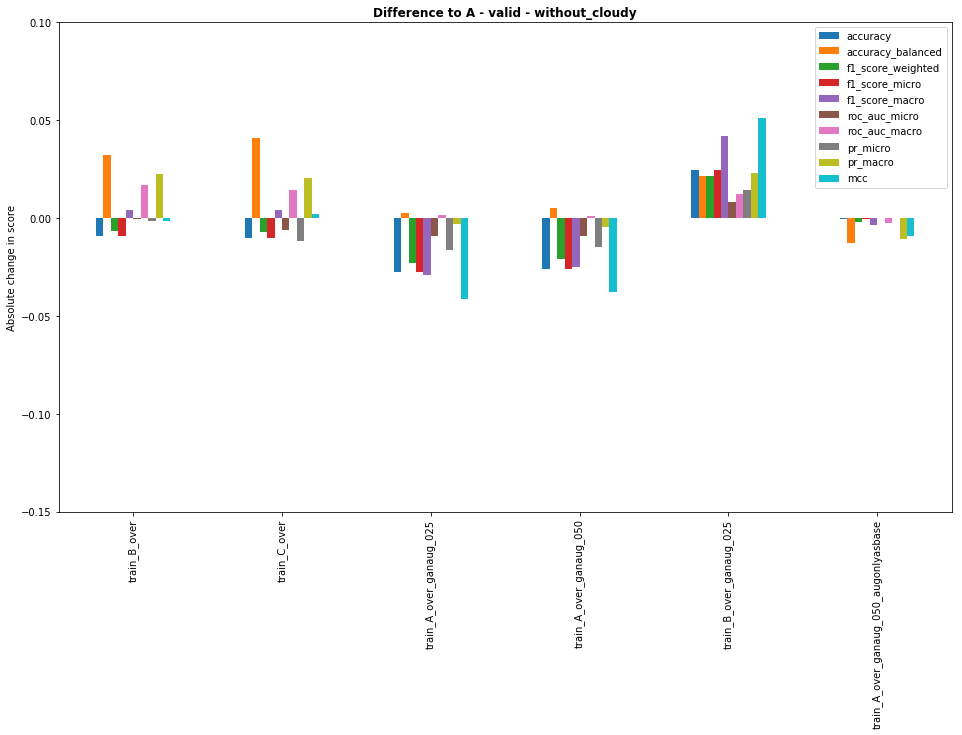

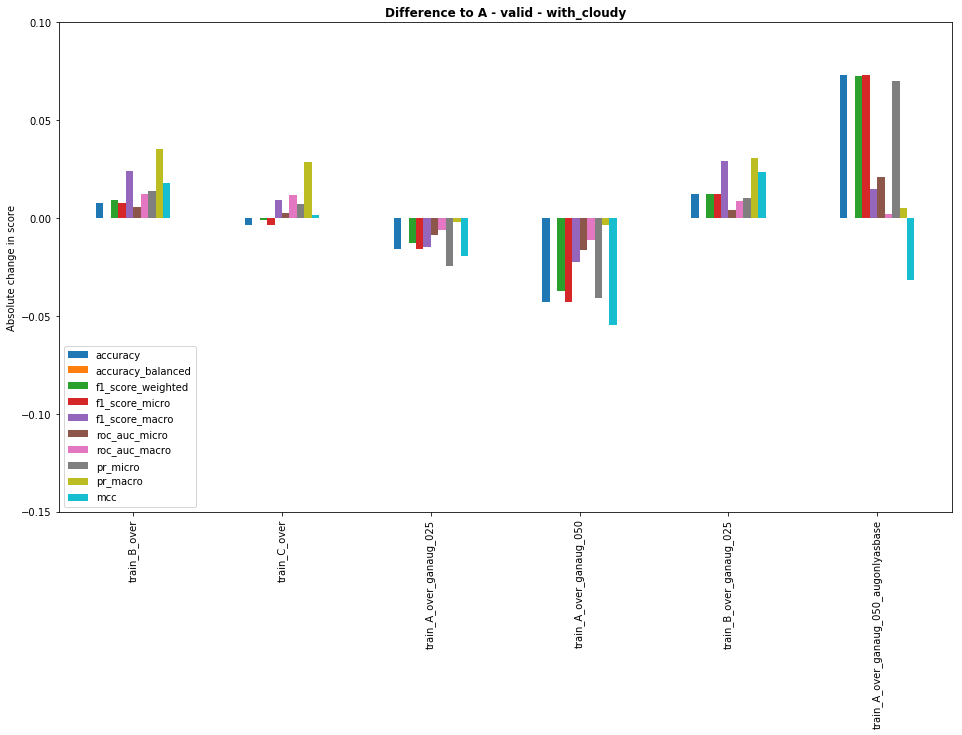

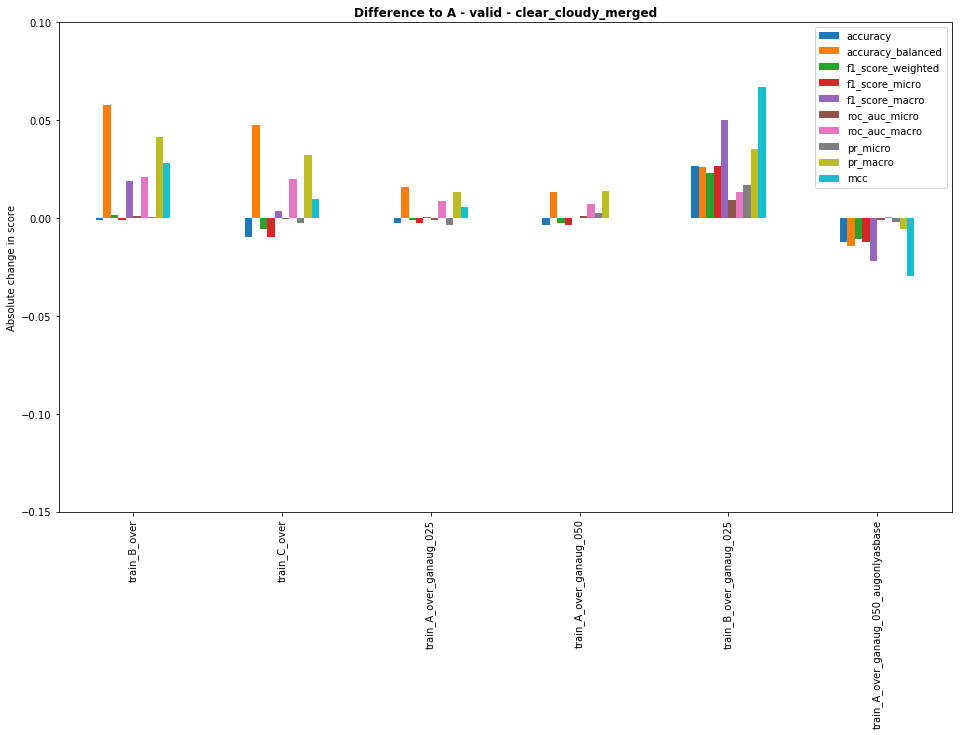

In [13]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==run, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {run}", fontweight="bold")

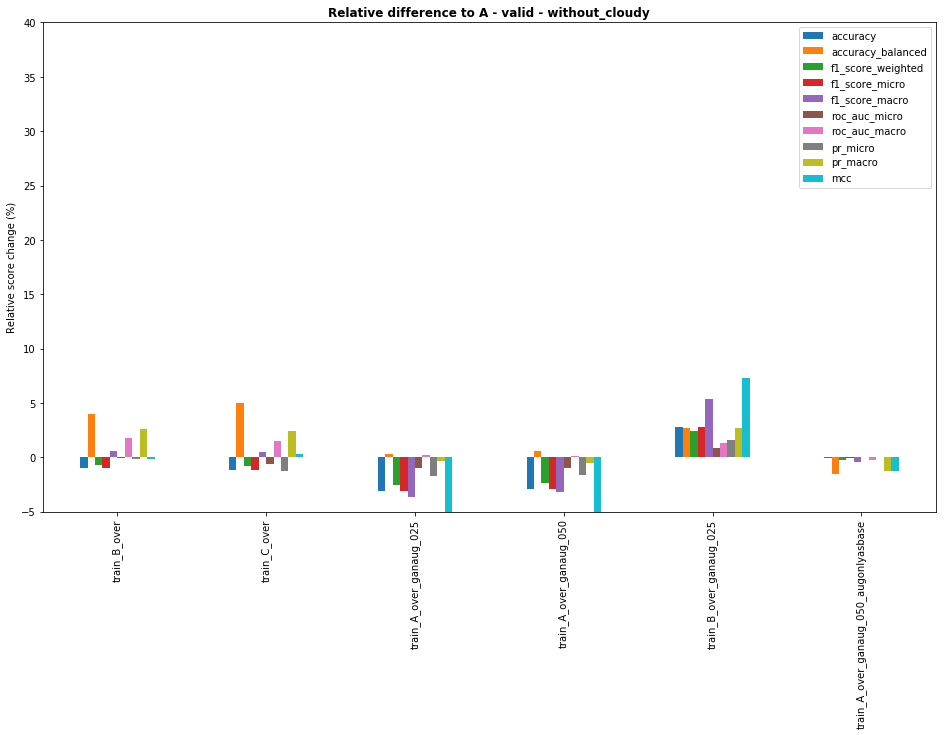

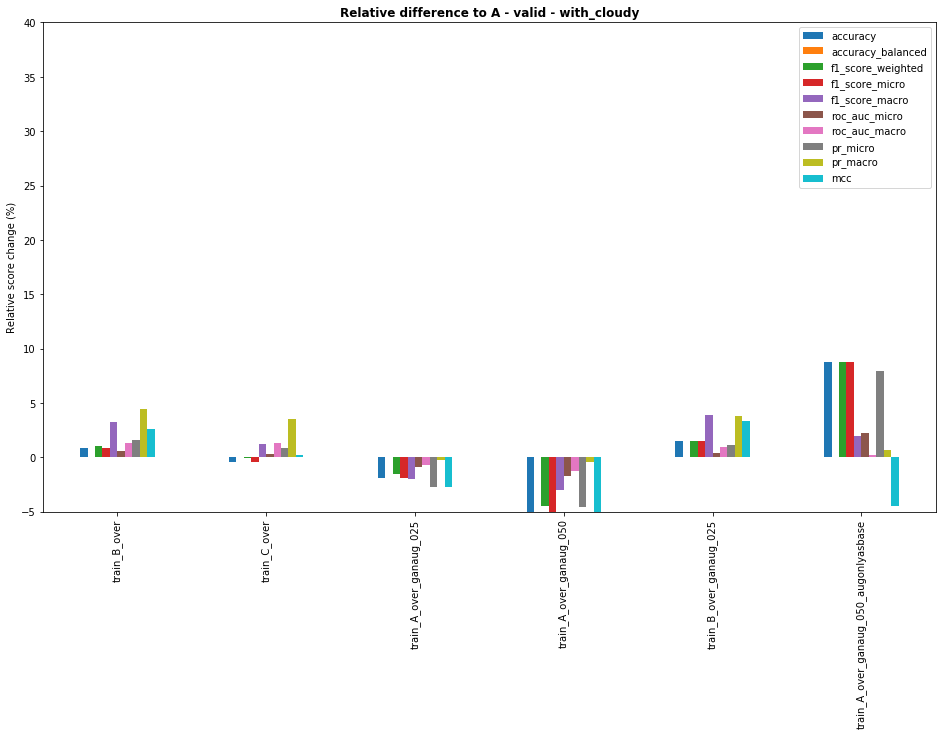

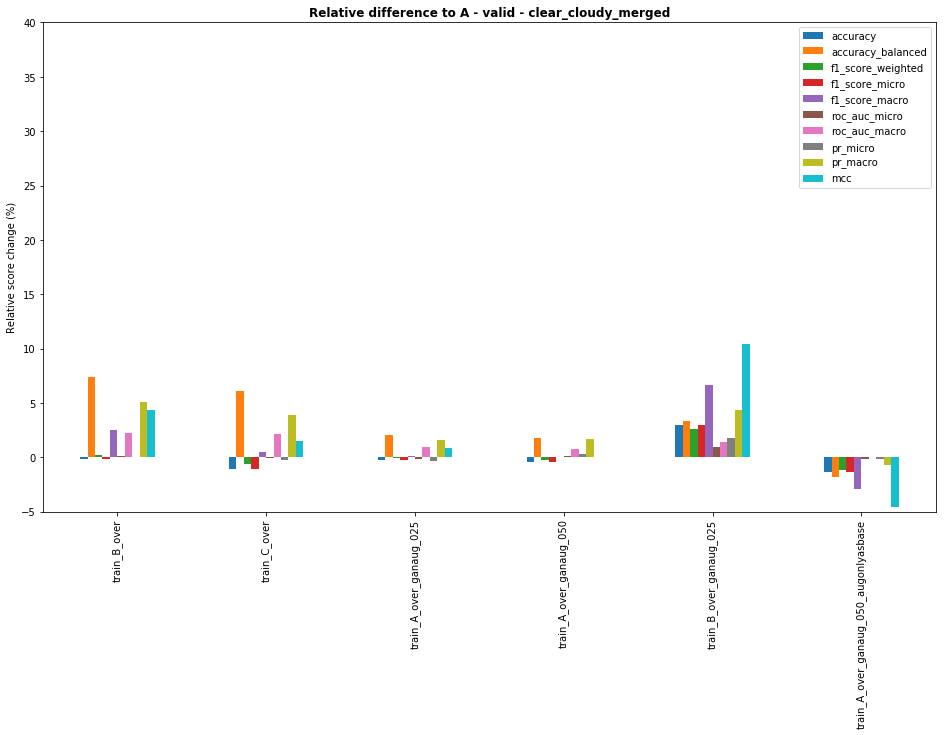

In [14]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel.run==run, :].reset_index(drop=True)
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
    ax = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Relative score change (%)")
    ax.set_ylim(-5, 40)
    ax.set_title(f"Relative difference to A - {split} - {run}", fontweight="bold")

In [15]:
df_cursplit_diff_rel.trial = df_cursplit_diff_rel.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day to Day-R50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day to Day-R50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
if additional_subtract_from_AUGONLYASBASE_for_plot:
    df_cursplit_diff_rel_aoab.trial = df_cursplit_diff_rel_aoab.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day/2 to Day-A50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day/2 to Day-A50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
    df_cursplit_diff_rel = pd.concat([df_cursplit_diff_rel, df_cursplit_diff_rel_aoab], axis = 0).reset_index(drop = True)

layout["title"] = "Impact of GAN-based augmentation (valid set)"
layout["yaxis"]["title"] = "Relative score change (%)"

run = "clear_cloudy_merged" 
df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.run == run, :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.trial.isin(["Day to Day-R50-Real", "Day to Day-R50-Fake", "Day/2 to Day-A50-Real", "Day/2 to Day-A50-Fake"]), :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print]

fig = df_cursplit_diff_rel_plot.iplot(kind = "bar", y = ["accuracy_balanced", "f1_score_micro", "f1_score_macro", "pr_micro", "pr_macro"], layout = layout, asFigure = True)
py.offline.iplot(fig, show_link = False, config = config)

### Valid-Night

In [16]:
# Print metrics for selected epoch of each run and trial
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0.867368,0.715143,0.873049,0.867368,0.692433,0.951242,0.873234,0.912646,0.736104,0.56594
1,11,train_B_over,without_cloudy,0.831579,0.791155,0.848641,0.831579,0.68439,0.938057,0.922697,0.887725,0.807588,0.560136
2,8,train_C_over,without_cloudy,0.849474,0.802404,0.863145,0.849474,0.707888,0.946032,0.929101,0.901229,0.819158,0.589446
3,5,train_A_over_ganaug_025,without_cloudy,0.797895,0.719281,0.823131,0.797895,0.633336,0.91597,0.877043,0.852974,0.734167,0.481766
4,14,train_A_over_ganaug_050,without_cloudy,0.82,0.743423,0.839936,0.82,0.666828,0.929153,0.885946,0.874683,0.741188,0.513636
5,38,train_B_over_ganaug_025,without_cloudy,0.9,0.751402,0.899194,0.9,0.76098,0.969504,0.909116,0.94585,0.796231,0.640066
6,15,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.863158,0.685867,0.867305,0.863158,0.671568,0.947698,0.864997,0.908487,0.706798,0.540897
7,26,train_A_over,with_cloudy,0.842,NaN,0.83676,0.842,0.625347,0.946179,0.844902,0.872777,0.641828,0.520873
8,34,train_B_over,with_cloudy,0.866,NaN,0.863483,0.866,0.69818,0.960607,0.889369,0.909754,0.73939,0.607587
9,39,train_C_over,with_cloudy,0.849,NaN,0.851635,0.849,0.687554,0.957516,0.89354,0.899728,0.737191,0.581551


In [17]:
# Print diffierence of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Difference to A ===")
df_cursplit_diff = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff.loc[r, metrics2print] = df_cursplit.loc[r,metrics2print] - df_cursplit.loc[r_ref,metrics2print]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night === Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,11,train_B_over,without_cloudy,-0.0357895,0.0760125,-0.0244077,-0.0357895,-0.00804336,-0.0131845,0.0494631,-0.0249214,0.0714838,-0.00580399
2,8,train_C_over,without_cloudy,-0.0178947,0.0872611,-0.00990371,-0.0178947,0.0154544,-0.00520997,0.0558665,-0.0114178,0.083054,0.0235056
3,5,train_A_over_ganaug_025,without_cloudy,-0.0694737,0.00413833,-0.0499172,-0.0694737,-0.0590975,-0.035272,0.00380942,-0.0596724,-0.00193795,-0.0841738
4,14,train_A_over_ganaug_050,without_cloudy,-0.0473684,0.0282795,-0.0331124,-0.0473684,-0.0256054,-0.0220886,0.012712,-0.0379633,0.00508344,-0.0523039
5,38,train_B_over_ganaug_025,without_cloudy,0.0326316,0.036259,0.0261457,0.0326316,0.0685467,0.0182626,0.0358816,0.0332033,0.0601266,0.074126
6,15,train_A_over_ganaug_050_augonlyasbase,without_cloudy,-0.00421053,-0.0292762,-0.00574336,-0.00421053,-0.0208657,-0.00354349,-0.00823752,-0.00415938,-0.0293067,-0.0250428
7,26,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,34,train_B_over,with_cloudy,0.024,NaN,0.0267229,0.024,0.0728331,0.014428,0.044467,0.0369777,0.0975623,0.0867138
9,39,train_C_over,with_cloudy,0.007,NaN,0.0148746,0.007,0.0622066,0.0113373,0.0486378,0.0269516,0.0953633,0.0606782


In [18]:
# Print relative differences of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Relative difference to A ===")
df_cursplit_diff_rel = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff_rel.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff_rel.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel.loc[:, cols2print].head(df_cursplit_diff_rel.shape[0])


=== valid_night === Relative difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,11,train_B_over,without_cloudy,-4.12621,10.629,-2.79569,-4.12621,-1.16161,-1.38603,5.66436,-2.73068,9.7111,-1.02555
2,8,train_C_over,without_cloudy,-2.06311,12.2019,-1.13438,-2.06311,2.2319,-0.547702,6.39765,-1.25106,11.2829,4.15338
3,5,train_A_over_ganaug_025,without_cloudy,-8.00971,0.578671,-5.71757,-8.00971,-8.53475,-3.708,0.436243,-6.53839,-0.263271,-14.8733
4,14,train_A_over_ganaug_050,without_cloudy,-5.46117,3.95439,-3.79273,-5.46117,-3.69789,-2.32209,1.45573,-4.15969,0.690587,-9.24195
5,38,train_B_over_ganaug_025,without_cloudy,3.76214,5.07018,2.99475,3.76214,9.89939,1.91987,4.10905,3.63813,8.16822,13.0979
6,15,train_A_over_ganaug_050_augonlyasbase,without_cloudy,-0.485437,-4.09375,-0.657851,-0.485437,-3.01339,-0.372512,-0.943334,-0.455749,-3.98132,-4.425
7,26,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,34,train_B_over,with_cloudy,2.85036,NaN,3.19361,2.85036,11.6468,1.52487,5.26297,4.23679,15.2007,16.6478
9,39,train_C_over,with_cloudy,0.831354,NaN,1.77764,0.831354,9.94753,1.19822,5.75662,3.08803,14.8581,11.6493


In [19]:
###### FOR AUGONLYASBASE ######
df_cursplit_diff_rel_aoab = pd.DataFrame()
if additional_subtract_from_AUGONLYASBASE_for_plot == True:
    # Print relative differences of metrics for selected epoch of each run and trial to their reference trial
    print("\n===", split, "=== Relative difference to AUGONLYASBASE ===")
    df_cursplit_diff_rel_aoab = df_cursplit.copy()
    for r in range(df_cursplit.shape[0]):  # for each row
        r_ref = r//num_trials*num_trials + 6  # reference row to substract
        df_cursplit_diff_rel_aoab.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel_aoab.loc[:, cols2print].head(df_cursplit_diff_rel_aoab.shape[0])


=== valid_night === Relative difference to AUGONLYASBASE ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,12,train_A_over,without_cloudy,0.487805,4.26849,0.662207,0.487805,3.10702,0.373905,0.952318,0.457836,4.1464,4.62987
1,11,train_B_over,without_cloudy,-3.65854,15.3512,-2.152,-3.65854,1.90932,-1.01731,6.67062,-2.28534,14.2602,3.55684
2,8,train_C_over,without_cloudy,-1.58537,16.9912,-0.479687,-1.58537,5.40827,-0.175845,7.4109,-0.798955,15.8971,8.97555
3,5,train_A_over_ganaug_025,without_cloudy,-7.56098,4.87186,-5.09323,-7.56098,-5.69291,-3.34796,1.39272,-6.11049,3.87221,-10.932
4,14,train_A_over_ganaug_050,without_cloudy,-5,8.39167,-3.15564,-5,-0.705759,-1.95686,2.42191,-3.7209,4.86562,-5.03997
5,38,train_B_over_ganaug_025,without_cloudy,4.26829,9.55509,3.67679,4.26829,13.314,2.30095,5.1005,4.11263,12.6533,18.3341
6,15,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0,0,0,0,0,0,0,0,0,0
7,26,train_A_over,with_cloudy,-4.85876,NaN,-4.5505,-4.85876,-5.48268,-1.689,-2.94239,-6.84948,-8.07033,-1.21483
8,34,train_B_over,with_cloudy,-2.14689,NaN,-1.50221,-2.14689,5.52559,-0.189883,2.16572,-2.90288,5.90363,15.2307
9,39,train_C_over,with_cloudy,-4.0678,NaN,-2.85375,-4.0678,3.91947,-0.511013,2.64485,-3.97296,5.58866,10.293


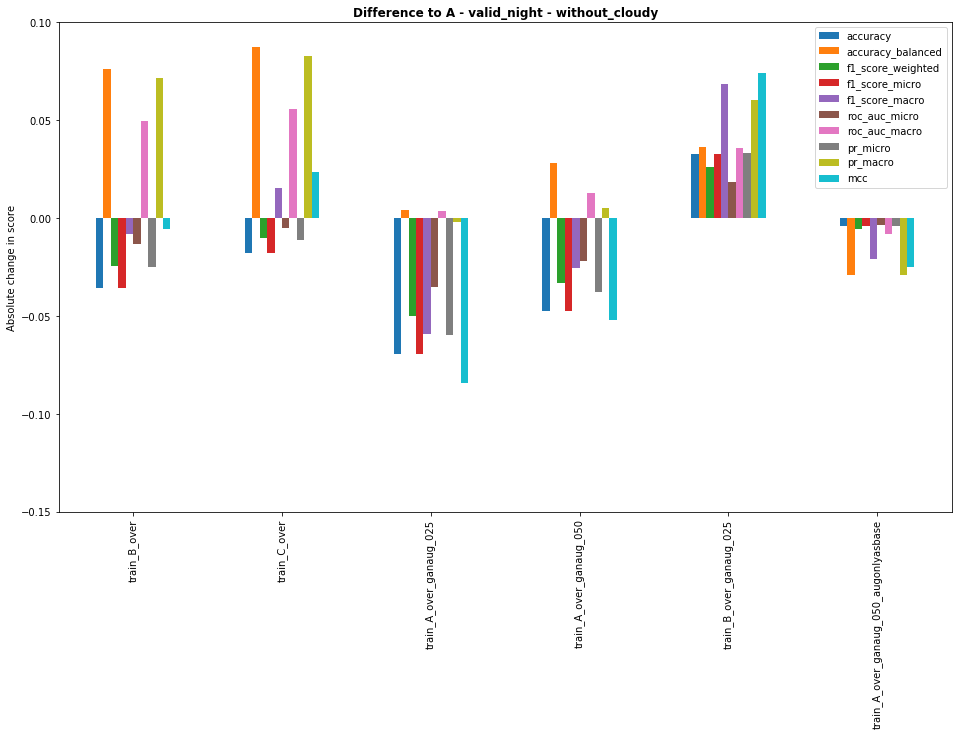

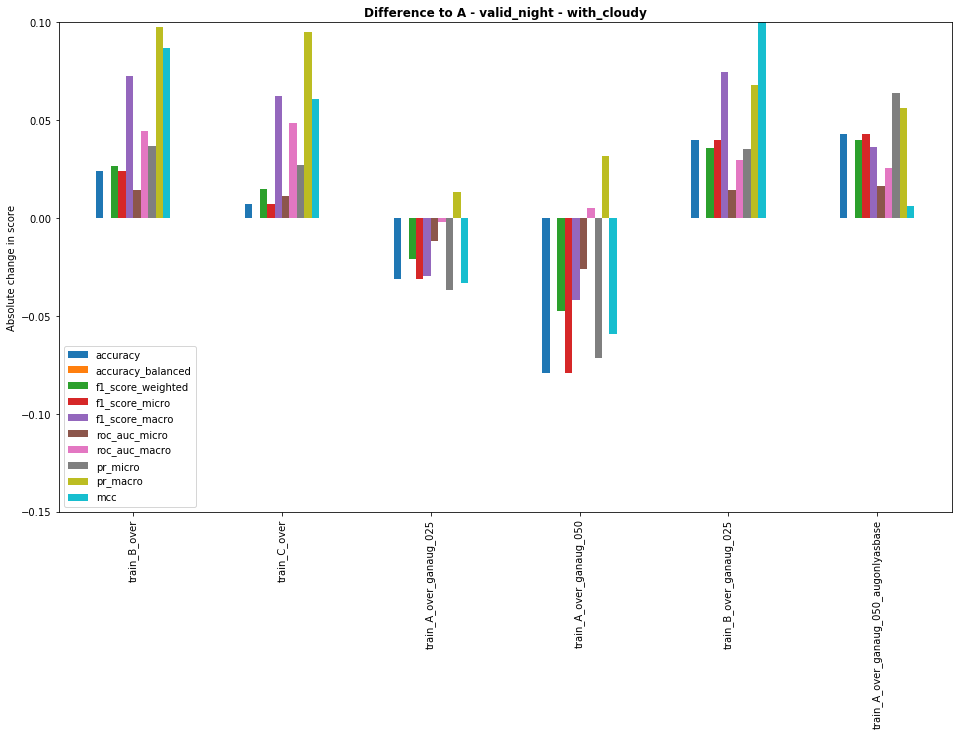

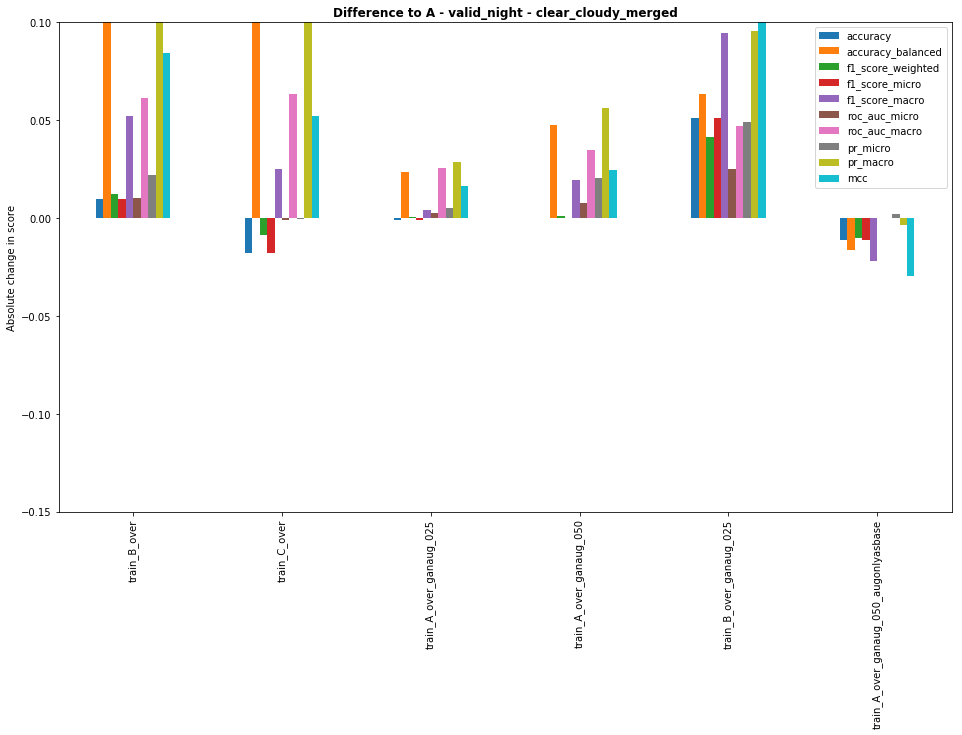

In [20]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==run, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {run}", fontweight="bold")

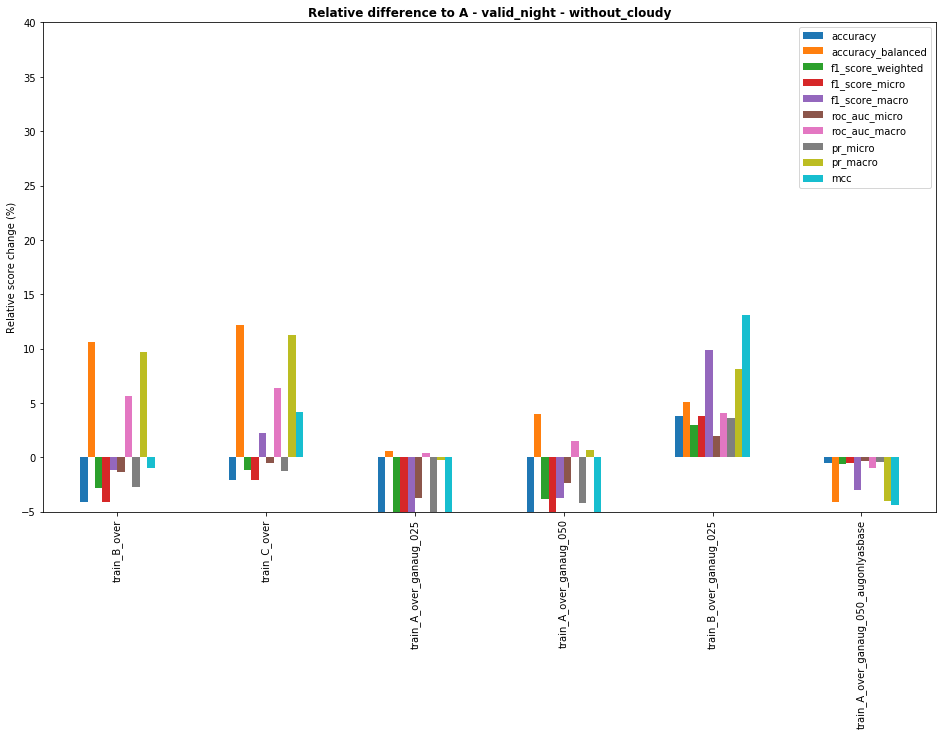

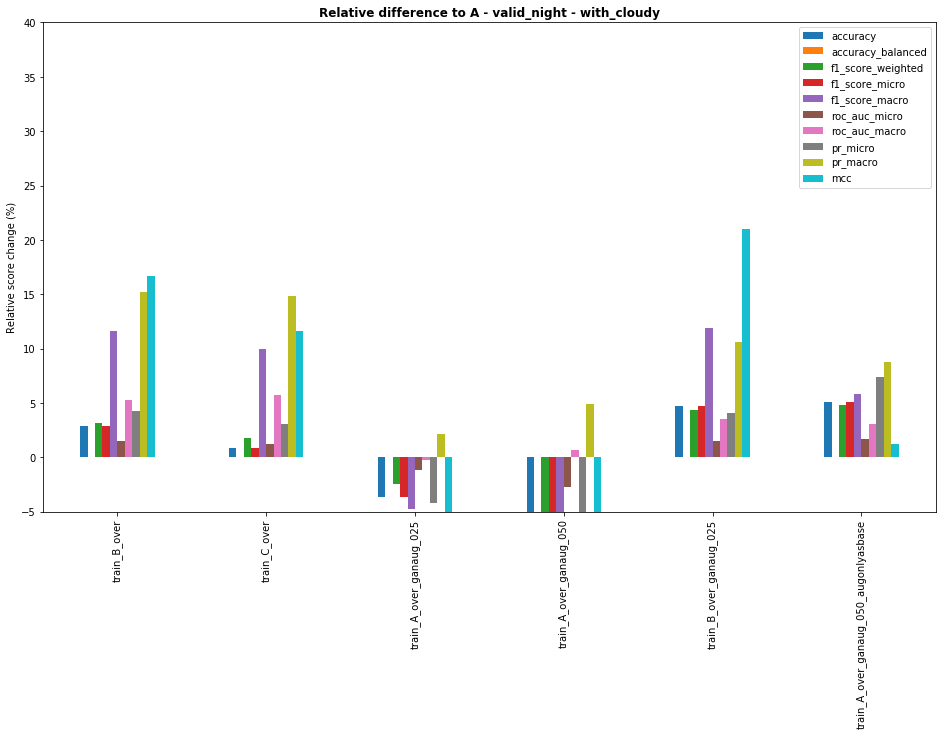

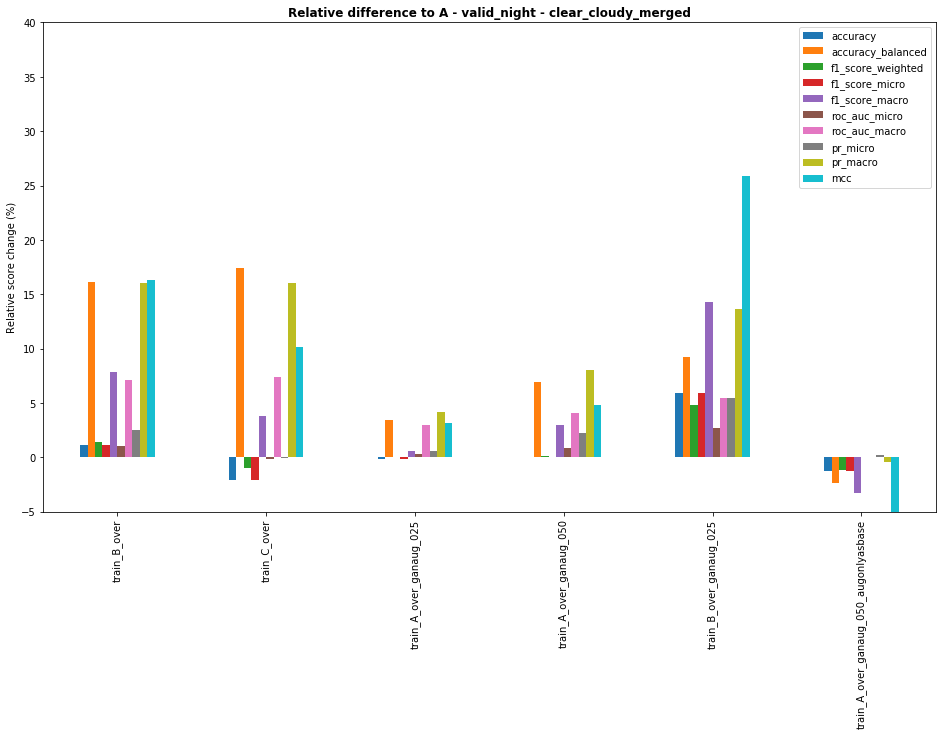

In [21]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel.run==run, :].reset_index(drop=True)
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
    ax = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Relative score change (%)")
    ax.set_ylim(-5, 40)
    ax.set_title(f"Relative difference to A - {split} - {run}", fontweight="bold")

In [22]:
df_cursplit_diff_rel.trial = df_cursplit_diff_rel.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day to Day-R50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day to Day-R50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
if additional_subtract_from_AUGONLYASBASE_for_plot:
    df_cursplit_diff_rel_aoab.trial = df_cursplit_diff_rel_aoab.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day/2 to Day-A50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day/2 to Day-A50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
    df_cursplit_diff_rel = pd.concat([df_cursplit_diff_rel, df_cursplit_diff_rel_aoab], axis = 0).reset_index(drop = True)

layout["title"] = "Impact of GAN-based augmentation (valid set, night fraction)"
layout["yaxis"]["title"] = "Relative score change (%)"

run = "clear_cloudy_merged" 
df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.run == run, :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.trial.isin(["Day to Day-R50-Real", "Day to Day-R50-Fake", "Day/2 to Day-A50-Real", "Day/2 to Day-A50-Fake"]), :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print]

fig = df_cursplit_diff_rel_plot.iplot(kind = "bar", y = ["accuracy_balanced", "f1_score_micro", "f1_score_macro", "pr_micro", "pr_macro"], layout = layout, asFigure = True)
py.offline.iplot(fig, show_link = False, config = config)

### Test-All

In [23]:
# Print metrics for selected epoch of each run and trial
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,17,train_A_over,without_cloudy,0.884665,0.808437,0.886574,0.884665,0.791956,0.966007,0.932166,0.941036,0.858202,0.693115
1,15,train_B_over,without_cloudy,0.858892,0.843072,0.86773,0.858892,0.770241,0.957637,0.947389,0.924655,0.878418,0.676608
2,20,train_C_over,without_cloudy,0.868557,0.842259,0.875445,0.868557,0.781828,0.961362,0.949714,0.930362,0.878773,0.687085
3,19,train_A_over_ganaug_025,without_cloudy,0.865335,0.808847,0.871591,0.865335,0.76469,0.959773,0.932484,0.929633,0.848335,0.666885
4,29,train_A_over_ganaug_050,without_cloudy,0.858247,0.813249,0.866088,0.858247,0.759012,0.956696,0.931753,0.924361,0.845846,0.659041
5,26,train_B_over_ganaug_025,without_cloudy,0.909149,0.821853,0.908854,0.909149,0.824001,0.972823,0.944047,0.952645,0.874375,0.748665
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.884665,0.801586,0.886086,0.884665,0.789343,0.965816,0.93151,0.941132,0.851242,0.690237
7,35,train_A_over,with_cloudy,0.8485,NaN,0.848104,0.8485,0.776043,0.958287,0.930479,0.898752,0.831869,0.730185
8,35,train_B_over,with_cloudy,0.8555,NaN,0.855876,0.8555,0.793282,0.962279,0.94287,0.902924,0.847821,0.745822
9,35,train_C_over,with_cloudy,0.85,NaN,0.850954,0.85,0.782636,0.961269,0.944,0.90301,0.850694,0.736677


In [24]:
# Print diffierence of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Difference to A ===")
df_cursplit_diff = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff.loc[r, metrics2print] = df_cursplit.loc[r,metrics2print] - df_cursplit.loc[r_ref,metrics2print]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test === Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,17,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,15,train_B_over,without_cloudy,-0.0257732,0.034635,-0.0188436,-0.0257732,-0.0217149,-0.00837037,0.015223,-0.0163808,0.0202161,-0.0165065
2,20,train_C_over,without_cloudy,-0.0161082,0.0338221,-0.0111288,-0.0161082,-0.0101276,-0.00464472,0.0175476,-0.0106738,0.0205709,-0.00602929
3,19,train_A_over_ganaug_025,without_cloudy,-0.0193299,0.000409959,-0.0149822,-0.0193299,-0.0272659,-0.00623447,0.000317974,-0.0114033,-0.00986668,-0.0262299
4,29,train_A_over_ganaug_050,without_cloudy,-0.0264175,0.00481238,-0.0204858,-0.0264175,-0.0329438,-0.00931082,-0.000413806,-0.0166745,-0.0123553,-0.0340734
5,26,train_B_over_ganaug_025,without_cloudy,0.0244845,0.013416,0.0222808,0.0244845,0.0320452,0.0068157,0.0118802,0.0116092,0.0161737,0.0555507
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0,-0.00685015,-0.000487575,0,-0.0026125,-0.000190974,-0.000656564,9.5594e-05,-0.00695928,-0.0028779
7,35,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,35,train_B_over,with_cloudy,0.007,NaN,0.00777179,0.007,0.017239,0.00399217,0.0123908,0.00417213,0.0159515,0.0156377
9,35,train_C_over,with_cloudy,0.0015,NaN,0.00284948,0.0015,0.00659299,0.00298183,0.0135212,0.00425819,0.0188246,0.00649252


In [25]:
# Print relative differences of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Relative difference to A ===")
df_cursplit_diff_rel = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff_rel.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff_rel.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel.loc[:, cols2print].head(df_cursplit_diff_rel.shape[0])


=== test === Relative difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,17,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,15,train_B_over,without_cloudy,-2.91333,4.2842,-2.12544,-2.91333,-2.74193,-0.866492,1.63307,-1.74072,2.35564,-2.38149
2,20,train_C_over,without_cloudy,-1.82083,4.18365,-1.25526,-1.82083,-1.27881,-0.480816,1.88246,-1.13426,2.39698,-0.869884
3,19,train_A_over_ganaug_025,without_cloudy,-2.185,0.0507101,-1.6899,-2.185,-3.44286,-0.645386,0.0341113,-1.21178,-1.14969,-3.78435
4,29,train_A_over_ganaug_050,without_cloudy,-2.98616,0.59527,-2.31067,-2.98616,-4.15981,-0.963846,-0.0443918,-1.77193,-1.43967,-4.91598
5,26,train_B_over_ganaug_025,without_cloudy,2.76766,1.6595,2.51313,2.76766,4.04634,0.705554,1.27447,1.23366,1.8846,8.01465
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0,-0.847333,-0.0549954,0,-0.32988,-0.0197694,-0.0704343,0.0101584,-0.810915,-0.415213
7,35,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,35,train_B_over,with_cloudy,0.824985,NaN,0.916372,0.824985,2.2214,0.416594,1.33165,0.464214,1.91755,2.14161
9,35,train_C_over,with_cloudy,0.176783,NaN,0.335982,0.176783,0.849565,0.311163,1.45314,0.473789,2.26292,0.889161


In [26]:
###### FOR AUGONLYASBASE ######
df_cursplit_diff_rel_aoab = pd.DataFrame()
if additional_subtract_from_AUGONLYASBASE_for_plot == True:
    # Print relative differences of metrics for selected epoch of each run and trial to their reference trial
    print("\n===", split, "=== Relative difference to AUGONLYASBASE ===")
    df_cursplit_diff_rel_aoab = df_cursplit.copy()
    for r in range(df_cursplit.shape[0]):  # for each row
        r_ref = r//num_trials*num_trials + 6  # reference row to substract
        df_cursplit_diff_rel_aoab.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel_aoab.loc[:, cols2print].head(df_cursplit_diff_rel_aoab.shape[0])


=== test === Relative difference to AUGONLYASBASE ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,17,train_A_over,without_cloudy,0,0.854574,0.0550257,0,0.330972,0.0197733,0.0704839,-0.0101573,0.817544,0.416944
1,15,train_B_over,without_cloudy,-2.91333,5.17539,-2.07158,-2.91333,-2.42003,-0.84689,1.70471,-1.7507,3.19244,-1.97448
2,20,train_C_over,without_cloudy,-1.82083,5.07397,-1.20093,-1.82083,-0.952073,-0.461138,1.95427,-1.1443,3.23412,-0.456567
3,19,train_A_over_ganaug_025,without_cloudy,-2.185,0.905718,-1.63581,-2.185,-3.12328,-0.62574,0.104619,-1.22181,-0.341547,-3.38318
4,29,train_A_over_ganaug_050,without_cloudy,-2.98616,1.45493,-2.25691,-2.98616,-3.8426,-0.944263,0.0260608,-1.78191,-0.633895,-4.51953
5,26,train_B_over_ganaug_025,without_cloudy,2.76766,2.52826,2.56954,2.76766,4.3907,0.725467,1.34585,1.22338,2.71755,8.46501
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0,0,0,0,0,0,0,0,0,0
7,35,train_A_over,with_cloudy,-7.11549,NaN,-6.94123,-7.11549,-1.42141,-1.71321,0.633313,-6.04162,1.01015,5.31082
8,35,train_B_over,with_cloudy,-6.34921,NaN,-6.08846,-6.34921,0.768413,-1.30376,1.9734,-5.60546,2.94707,7.56617
9,35,train_C_over,with_cloudy,-6.95129,NaN,-6.62857,-6.95129,-0.583923,-1.40738,2.09566,-5.59646,3.29593,6.2472


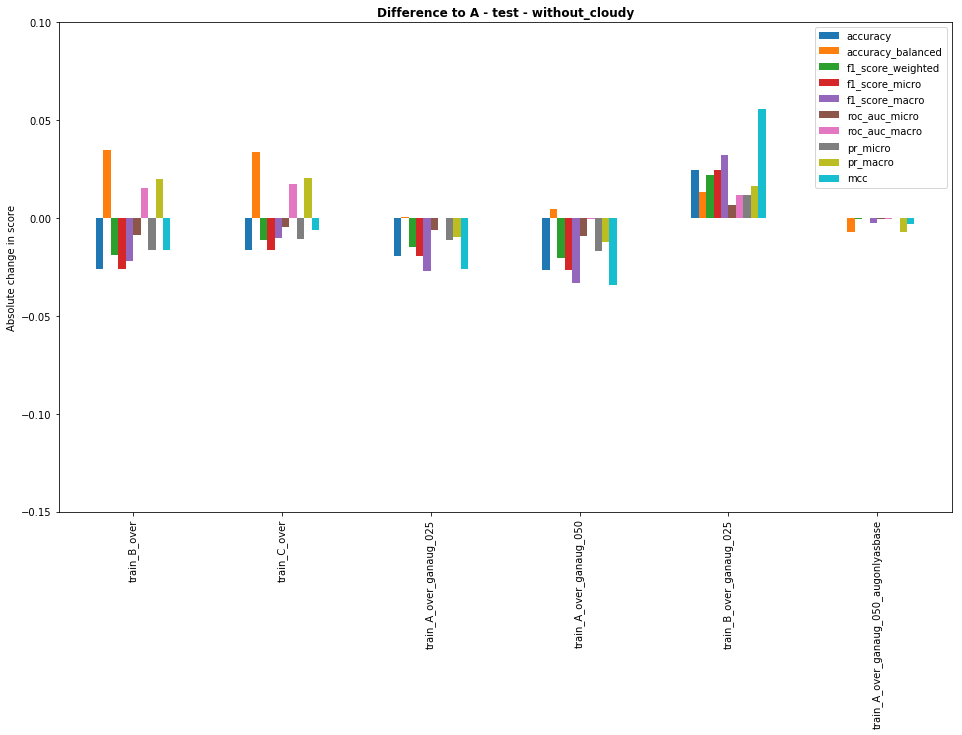

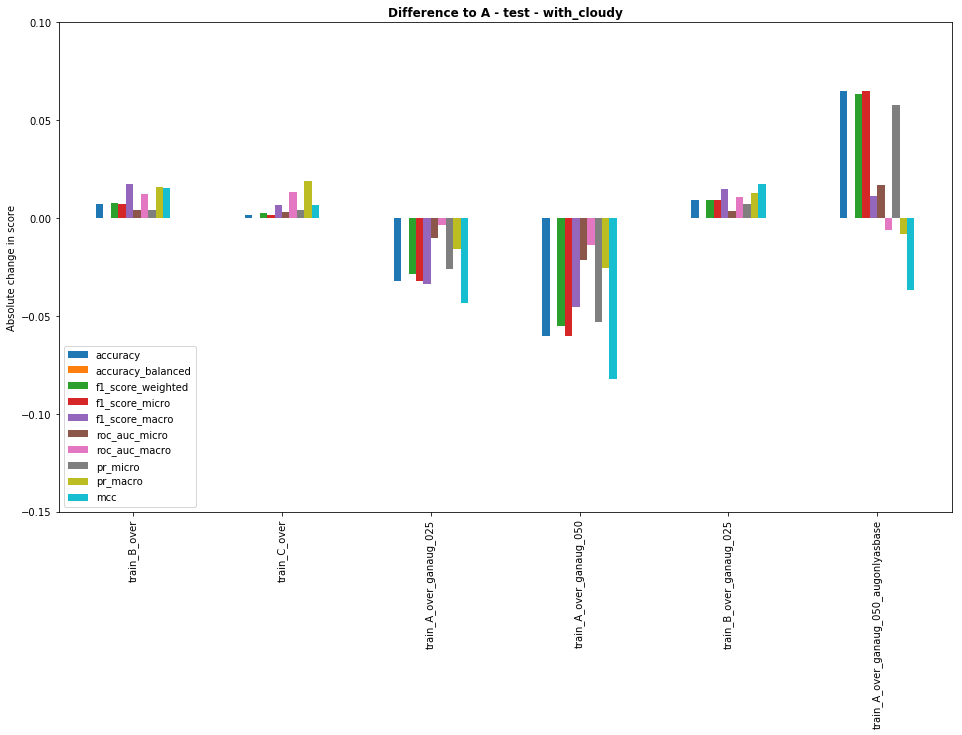

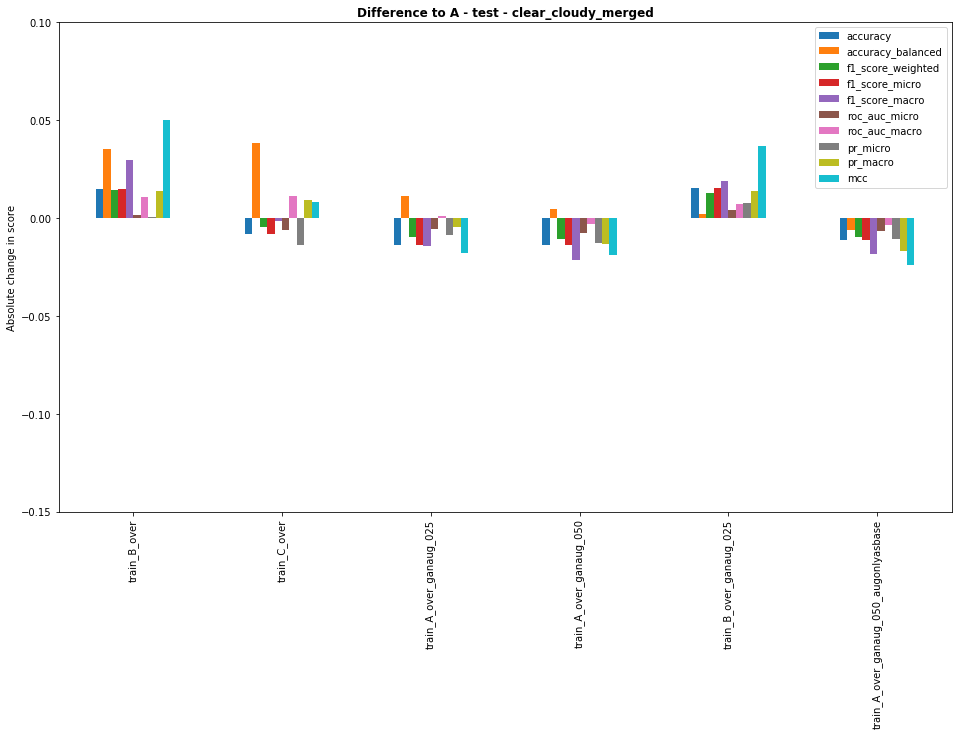

In [27]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==run, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {run}", fontweight="bold")

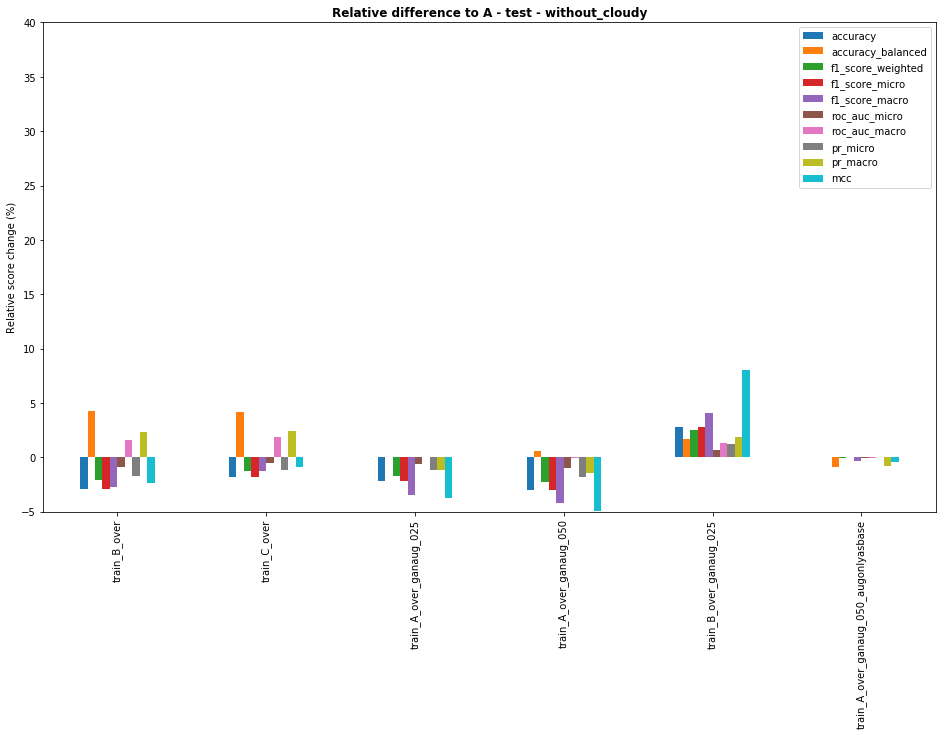

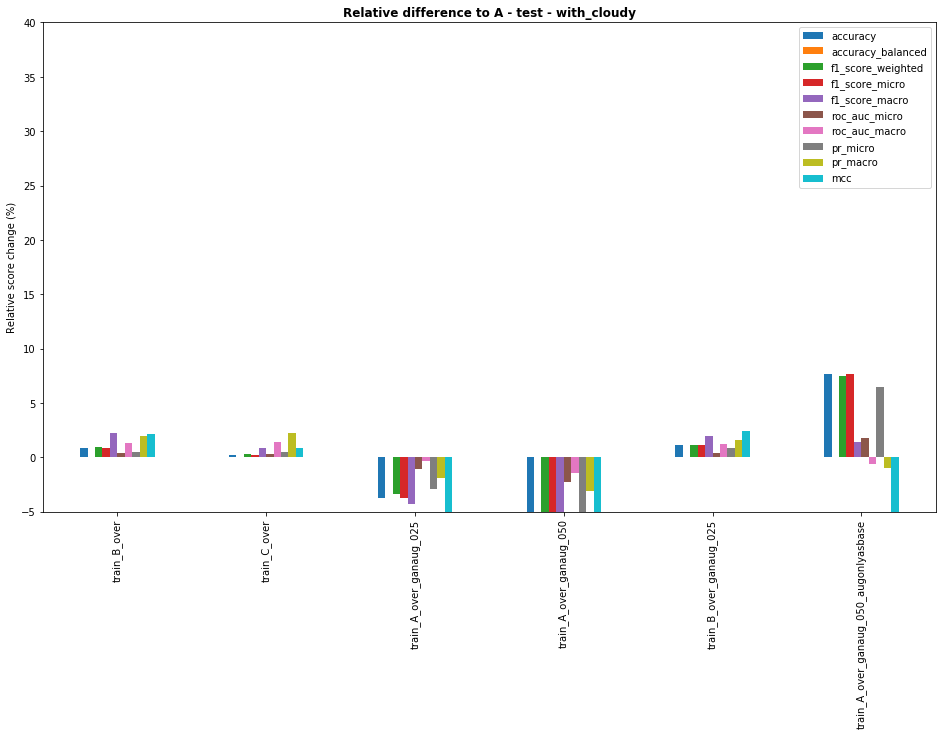

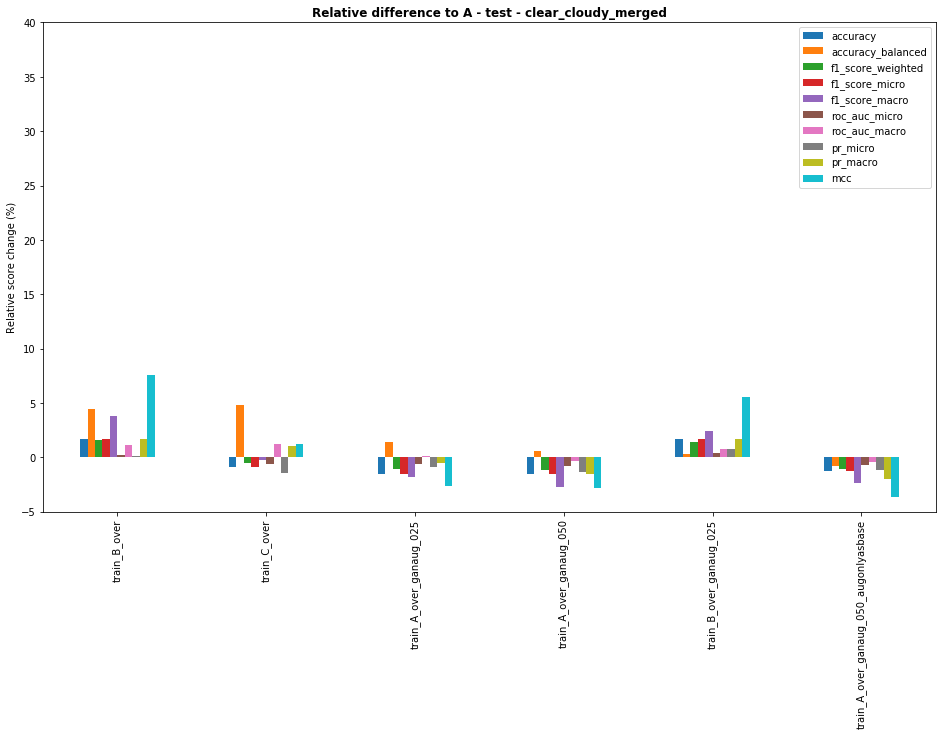

In [28]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel.run==run, :].reset_index(drop=True)
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
    ax = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Relative score change (%)")
    ax.set_ylim(-5, 40)
    ax.set_title(f"Relative difference to A - {split} - {run}", fontweight="bold")

In [29]:
df_cursplit_diff_rel.trial = df_cursplit_diff_rel.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day to Day-R50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day to Day-R50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
if additional_subtract_from_AUGONLYASBASE_for_plot:
    df_cursplit_diff_rel_aoab.trial = df_cursplit_diff_rel_aoab.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day/2 to Day-A50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day/2 to Day-A50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
    df_cursplit_diff_rel = pd.concat([df_cursplit_diff_rel, df_cursplit_diff_rel_aoab], axis = 0).reset_index(drop = True)

layout["title"] = "Impact of GAN-based augmentation (test set)"
layout["yaxis"]["title"] = "Relative score change (%)"

run = "clear_cloudy_merged" 
df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.run == run, :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.trial.isin(["Day to Day-R50-Real", "Day to Day-R50-Fake", "Day/2 to Day-A50-Real", "Day/2 to Day-A50-Fake"]), :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print]

fig = df_cursplit_diff_rel_plot.iplot(kind = "bar", y = ["accuracy_balanced", "f1_score_micro", "f1_score_macro", "pr_micro", "pr_macro"], layout = layout, asFigure = True)
py.offline.iplot(fig, show_link = False, config = config)

### Test-Night

In [30]:
# Print diffierence of metrics for selected epoch of each run and trial to their reference trial
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,11,train_A_over,without_cloudy,0.829474,0.680077,0.840338,0.829474,0.646597,0.935927,0.852201,0.887263,0.714435,0.470129
1,15,train_B_over,without_cloudy,0.826316,0.780901,0.843997,0.826316,0.673845,0.934456,0.895603,0.877728,0.789309,0.548019
2,6,train_C_over,without_cloudy,0.824211,0.776154,0.841969,0.824211,0.671513,0.927498,0.89092,0.862618,0.780514,0.540428
3,10,train_A_over_ganaug_025,without_cloudy,0.816842,0.694612,0.834111,0.816842,0.635114,0.932113,0.860365,0.881158,0.720191,0.477988
4,12,train_A_over_ganaug_050,without_cloudy,0.805263,0.721525,0.827517,0.805263,0.636773,0.921782,0.860014,0.861951,0.720583,0.486652
5,32,train_B_over_ganaug_025,without_cloudy,0.904211,0.729155,0.901556,0.904211,0.744482,0.963587,0.886244,0.935263,0.773052,0.648875
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.861053,0.676639,0.861774,0.861053,0.672379,0.946824,0.849985,0.904351,0.686571,0.514889
7,35,train_A_over,with_cloudy,0.859,NaN,0.852067,0.859,0.657703,0.950415,0.846709,0.885453,0.682197,0.565803
8,16,train_B_over,with_cloudy,0.867,NaN,0.866862,0.867,0.701427,0.957618,0.890373,0.892606,0.742923,0.623218
9,40,train_C_over,with_cloudy,0.858,NaN,0.853619,0.858,0.659759,0.957056,0.886673,0.894478,0.743259,0.58184


In [31]:
# Print diffierence of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Difference to A ===")
df_cursplit_diff = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff.loc[r, metrics2print] = df_cursplit.loc[r,metrics2print] - df_cursplit.loc[r_ref,metrics2print]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night === Difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,11,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,15,train_B_over,without_cloudy,-0.00315789,0.100824,0.00365882,-0.00315789,0.027248,-0.00147091,0.0434019,-0.00953511,0.0748746,0.0778905
2,6,train_C_over,without_cloudy,-0.00526316,0.0960768,0.0016314,-0.00526316,0.0249163,-0.00842881,0.038719,-0.0246459,0.0660793,0.0702993
3,10,train_A_over_ganaug_025,without_cloudy,-0.0126316,0.014535,-0.00622707,-0.0126316,-0.0114827,-0.00381385,0.00816372,-0.00610543,0.00575656,0.00785906
4,12,train_A_over_ganaug_050,without_cloudy,-0.0242105,0.0414484,-0.0128211,-0.0242105,-0.00982428,-0.0141446,0.00781242,-0.0253129,0.00614852,0.016523
5,32,train_B_over_ganaug_025,without_cloudy,0.0747368,0.0490777,0.0612187,0.0747368,0.0978855,0.0276598,0.0340425,0.0479997,0.0586178,0.178747
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.0315789,-0.00343779,0.0214359,0.0315789,0.0257823,0.010897,-0.00221578,0.0170871,-0.0278634,0.0447605
7,35,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,16,train_B_over,with_cloudy,0.008,NaN,0.014795,0.008,0.0437235,0.00720333,0.0436637,0.00715261,0.0607258,0.0574151
9,40,train_C_over,with_cloudy,-0.001,NaN,0.00155211,-0.001,0.0020559,0.00664083,0.0399636,0.00902487,0.0610619,0.0160376


In [32]:
# Print relative differences of metrics for selected epoch of each run and trial to their reference trial
print("\n===", split, "=== Relative difference to A ===")
df_cursplit_diff_rel = df_cursplit.copy()
for r in range(df_cursplit.shape[0]):  # for each row
    if df_cursplit_diff_rel.loc[r, "trial"] == "train_B_over_ganaug_025" and not always_substract_A:  # substract B
        r_ref = r//num_trials*num_trials+1  # reference row to substract
    else: # substract A
        r_ref = r//num_trials*num_trials  # reference row to substract
    df_cursplit_diff_rel.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel.loc[:, cols2print].head(df_cursplit_diff_rel.shape[0])


=== test_night === Relative difference to A ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,11,train_A_over,without_cloudy,0,0,0,0,0,0,0,0,0,0
1,15,train_B_over,without_cloudy,-0.380711,14.8254,0.435399,-0.380711,4.21407,-0.157161,5.09292,-1.07467,10.4803,16.5679
2,6,train_C_over,without_cloudy,-0.634518,14.1273,0.194136,-0.634518,3.85344,-0.900584,4.54341,-2.77774,9.24918,14.9532
3,10,train_A_over_ganaug_025,without_cloudy,-1.52284,2.13726,-0.74102,-1.52284,-1.77586,-0.407494,0.957957,-0.688119,0.80575,1.67168
4,12,train_A_over_ganaug_050,without_cloudy,-2.91878,6.09467,-1.5257,-2.91878,-1.51938,-1.51129,0.916735,-2.85292,0.860613,3.51456
5,32,train_B_over_ganaug_025,without_cloudy,9.01015,7.21648,7.28501,9.01015,15.1386,2.95534,3.99465,5.40986,8.20477,38.0208
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,3.80711,-0.5055,2.55087,3.80711,3.98738,1.1643,-0.260006,1.92582,-3.90006,9.5209
7,35,train_A_over,with_cloudy,0,NaN,0,0,0,0,0,0,0,0
8,16,train_B_over,with_cloudy,0.931315,NaN,1.73637,0.931315,6.64791,0.757915,5.15687,0.807791,8.90149,10.1475
9,40,train_C_over,with_cloudy,-0.116414,NaN,0.182158,-0.116414,0.312588,0.69873,4.71987,1.01924,8.95076,2.83448


In [33]:
###### FOR AUGONLYASBASE ######
df_cursplit_diff_rel_aoab = pd.DataFrame()
if additional_subtract_from_AUGONLYASBASE_for_plot == True:
    # Print relative differences of metrics for selected epoch of each run and trial to their reference trial
    print("\n===", split, "=== Relative difference to AUGONLYASBASE ===")
    df_cursplit_diff_rel_aoab = df_cursplit.copy()
    for r in range(df_cursplit.shape[0]):  # for each row
        r_ref = r//num_trials*num_trials + 6  # reference row to substract
        df_cursplit_diff_rel_aoab.loc[r, metrics2print] = ((df_cursplit.loc[r, metrics2print] - df_cursplit.loc[r_ref, metrics2print]) / df_cursplit.loc[r_ref, metrics2print]) * 100
df_cursplit_diff_rel_aoab.loc[:, cols2print].head(df_cursplit_diff_rel_aoab.shape[0])


=== test_night === Relative difference to AUGONLYASBASE ===


,epoch,trial,run,accuracy,accuracy_balanced,f1_score_weighted,f1_score_micro,f1_score_macro,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,11,train_A_over,without_cloudy,-3.66748,0.508068,-2.48742,-3.66748,-3.83448,-1.1509,0.260684,-1.88943,4.05833,-8.69323
1,15,train_B_over,without_cloudy,-4.03423,15.4088,-2.06285,-4.03423,0.217996,-1.30625,5.36688,-2.94379,14.9639,6.4344
2,6,train_C_over,without_cloudy,-4.27873,14.7072,-2.29811,-4.27873,-0.128797,-2.04111,4.81594,-4.61469,13.6829,4.96006
3,10,train_A_over_ganaug_025,without_cloudy,-5.13447,2.65619,-3.21,-5.13447,-5.54225,-1.5537,1.22114,-2.56455,4.89678,-7.16687
4,12,train_A_over_ganaug_050,without_cloudy,-6.47922,6.6337,-3.97517,-6.47922,-5.2956,-2.6448,1.17981,-4.68844,4.95387,-5.4842
5,32,train_B_over_ganaug_025,without_cloudy,5.01222,7.76122,4.61639,5.01222,10.7236,1.77043,4.26575,3.41822,12.5961,26.0223
6,20,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0,0,0,0,0,0,0,0,0,0
7,35,train_A_over,with_cloudy,-3.59147,NaN,-3.58184,-3.59147,-4.01546,-0.584049,0.439618,-3.5523,-0.784253,1.60582
8,16,train_B_over,with_cloudy,-2.6936,NaN,-1.90766,-2.6936,2.3655,0.169439,5.61916,-2.77321,8.04743,11.9163
9,40,train_C_over,with_cloudy,-3.7037,NaN,-3.4062,-3.7037,-3.71543,0.1106,5.18024,-2.56927,8.09631,4.48582


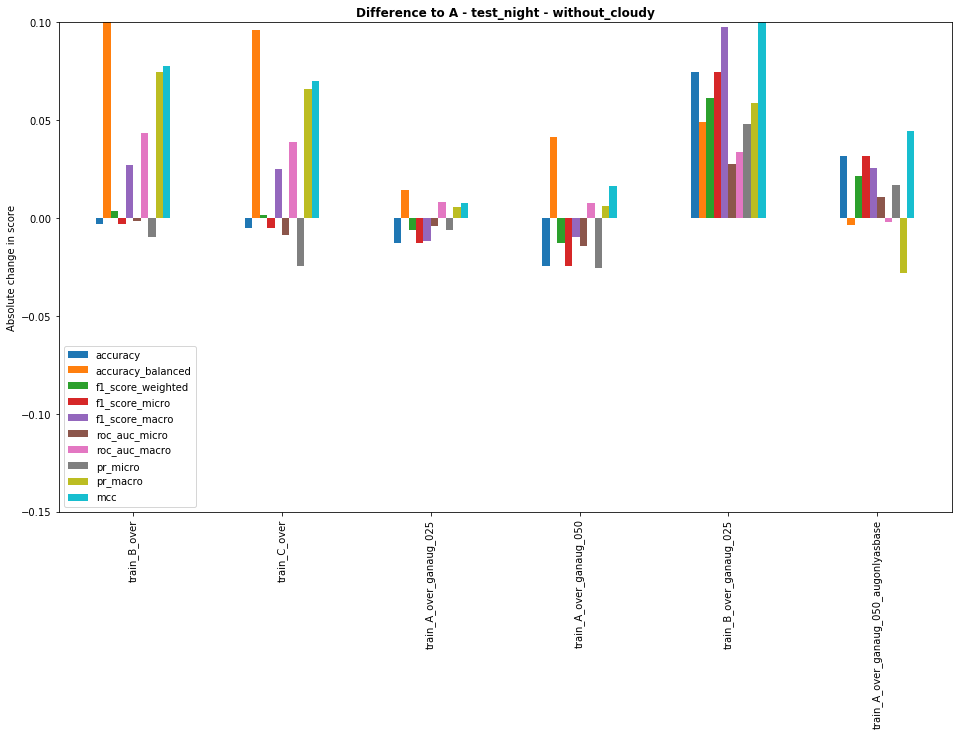

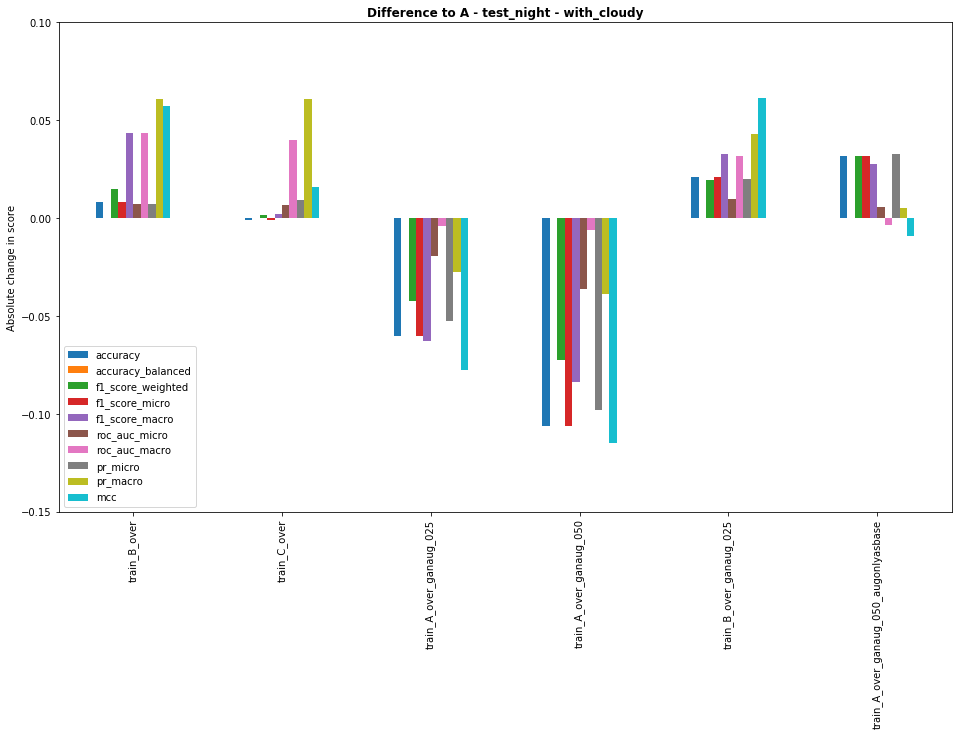

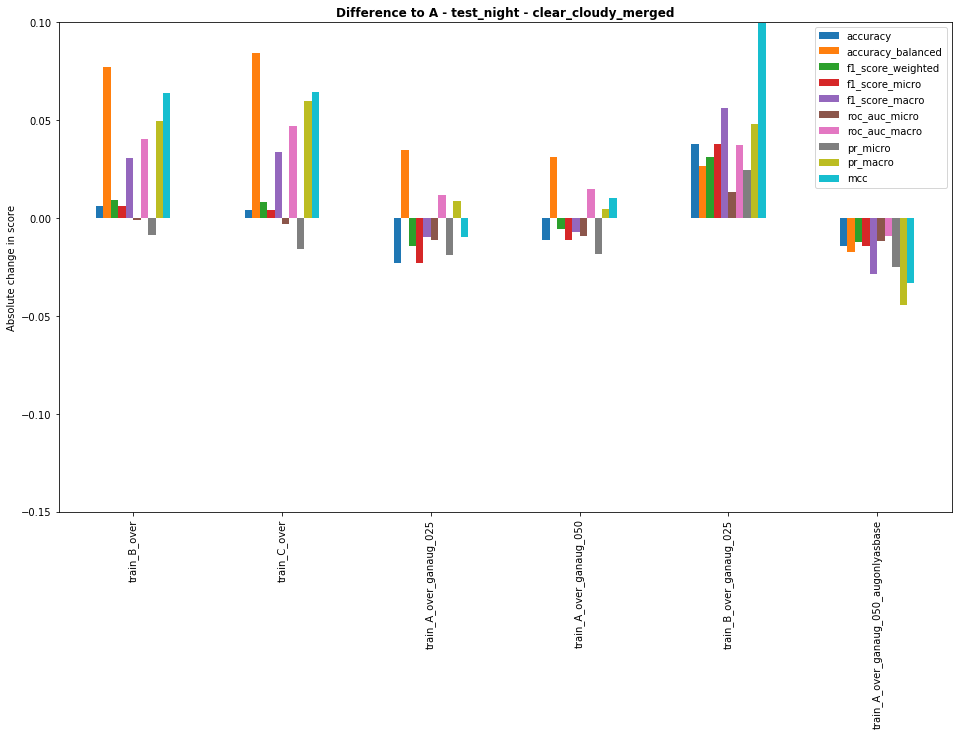

In [34]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==run, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {run}", fontweight="bold")

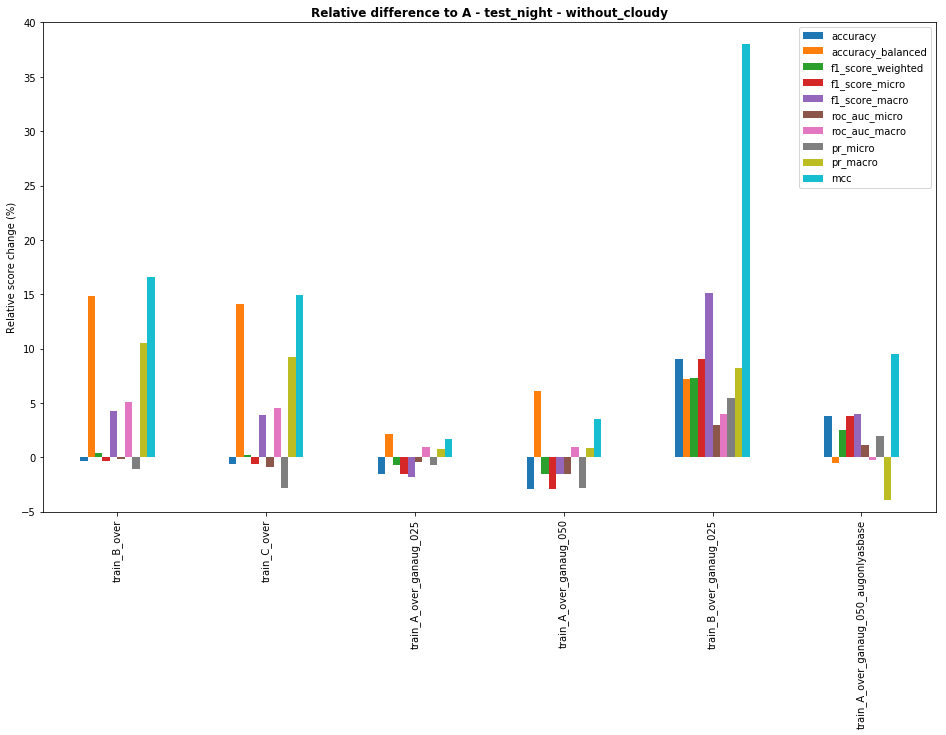

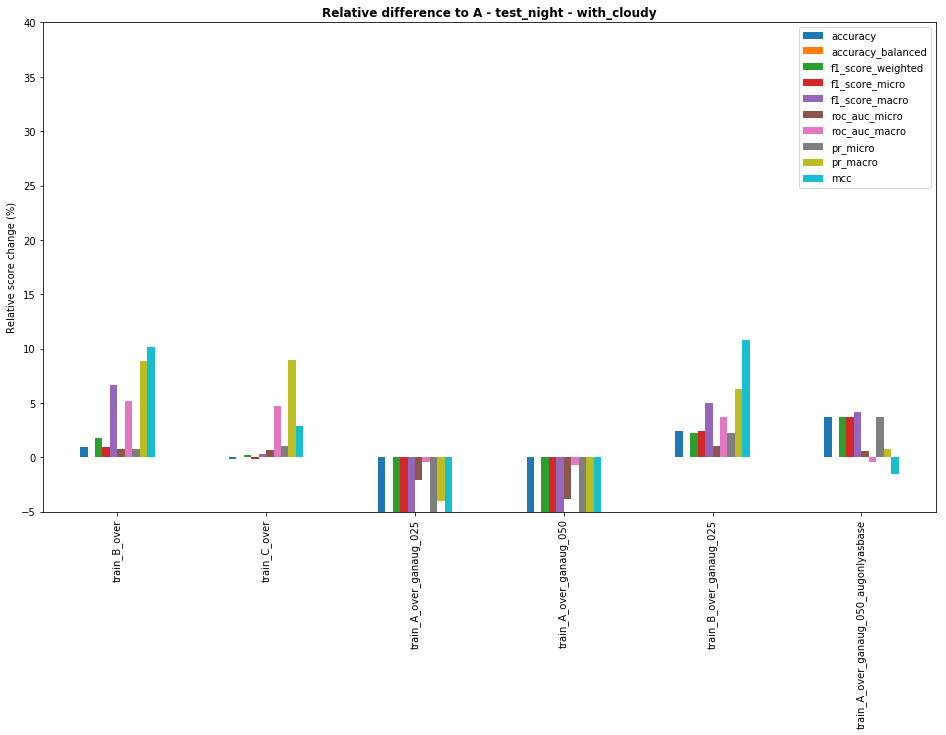

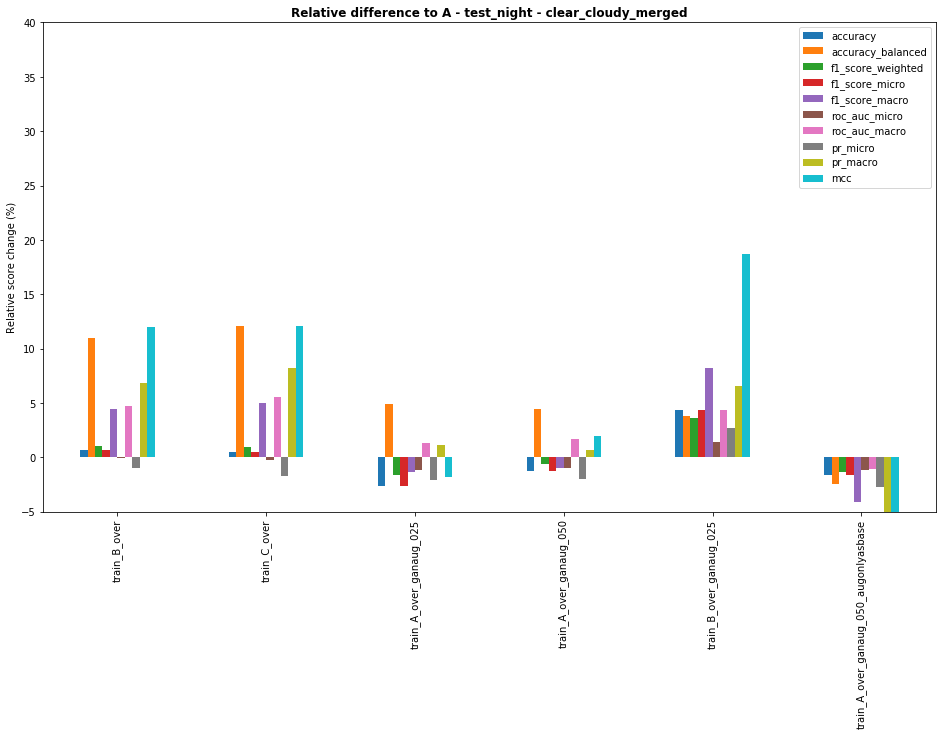

In [35]:
# Plot diffierence of metrics for selected epoch of each run and trial to their reference trial
for run in list_runs:
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel.run==run, :].reset_index(drop=True)
    df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
    ax = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Relative score change (%)")
    ax.set_ylim(-5, 40)
    ax.set_title(f"Relative difference to A - {split} - {run}", fontweight="bold")

In [36]:
df_cursplit_diff_rel.trial = df_cursplit_diff_rel.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day to Day-R50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day to Day-R50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
if additional_subtract_from_AUGONLYASBASE_for_plot:
    df_cursplit_diff_rel_aoab.trial = df_cursplit_diff_rel_aoab.trial.map({"train_A_over": "train_A_over", "train_B_over": "train_B_over", "train_C_over": "Day/2 to Day-A50-Real", "train_A_over_ganaug_025": "train_A_over_ganaug_025", "train_A_over_ganaug_050": "Day/2 to Day-A50-Fake", "train_B_over_ganaug_025": "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase": "train_A_over_ganaug_050_augonlyasbase"})
    df_cursplit_diff_rel = pd.concat([df_cursplit_diff_rel, df_cursplit_diff_rel_aoab], axis = 0).reset_index(drop = True)

layout["title"] = "Impact of GAN-based augmentation (test set, night fraction)"
layout["yaxis"]["title"] = "Relative score change (%)"

run = "clear_cloudy_merged" 
df_cursplit_diff_rel_plot = df_cursplit_diff_rel.copy()
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.run == run, :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[1:df_cursplit_diff_rel_plot.shape[0], :]
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.loc[df_cursplit_diff_rel_plot.trial.isin(["Day to Day-R50-Real", "Day to Day-R50-Fake", "Day/2 to Day-A50-Real", "Day/2 to Day-A50-Fake"]), :].reset_index(drop=True)
df_cursplit_diff_rel_plot = df_cursplit_diff_rel_plot.set_index(["trial"]).loc[:, metrics2print]

fig = df_cursplit_diff_rel_plot.iplot(kind = "bar", y = ["accuracy_balanced", "f1_score_micro", "f1_score_macro", "pr_micro", "pr_macro"], layout = layout, asFigure = True)
py.offline.iplot(fig, show_link = False, config = config)